In [8]:
# import os
# import random
# import shutil

# # Step 1: Define your main folder and output folder
# main_folder = 'places365'  # Replace with your main folder path
# output_folder = 'place365subset'      # Replace with your desired output folder path

# # Step 2: Collect all image file paths
# image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']
# image_paths = []

# for root, dirs, files in os.walk(main_folder):
#     for file in files:
#         if os.path.splitext(file)[1].lower() in image_extensions:
#             image_path = os.path.join(root, file)
#             image_paths.append(image_path)

# # Step 3: Check if there are at least 4051 images
# if len(image_paths) < 4051:
#     print(f"Only found {len(image_paths)} images. Cannot select 4051 images.")
# else:
#     # Step 4: Select 4051 random image paths
#     random_image_paths = random.sample(image_paths, 4051)

#     # Step 5: Create the output folder if it doesn't exist
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)
#         print(f"Folder '{output_folder}' created.")
#     else:
#         print(f"Folder '{output_folder}' already exists.")

#     # Step 6: Copy the selected images to the new folder
#     for i, image_path in enumerate(random_image_paths):
#         try:
#             # Get the image filename
#             image_name = os.path.basename(image_path)
#             # Define the destination path
#             destination = os.path.join(output_folder, image_name)
#             # Copy the image
#             shutil.copy(image_path, destination)
#             print(f"Copied {i+1}/{len(random_image_paths)}: {image_name}")
#         except Exception as e:
#             print(f"Error copying {image_path}: {e}")

#     print("Image copying completed.")

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt 
import numpy as np
import torchvision
from torchvision import datasets, models, transforms 
from torch.optim import lr_scheduler
import time 
import os 
import copy 
import torch.optim as optim 
import torch.utils
import sys
import random
import PIL
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#hyper parameters
batchsize=32
numepochs = 5
numclasses = 10
in_channel = 3
learningRate = 1e-3

In [4]:
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.225])

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
}

In [6]:
data_dir = 'binary classification data'
sets = ['train','val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
                  for x in ['train','val']}

In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize,
                                             shuffle = (True if (x == 'train') else False), num_workers=1,pin_memory=True)
              for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
print(class_names)

['liminal', 'normal']


In [780]:
def trainmodel(model,criterion,optimizer,scheduler,numepochs=25):
    since = time.time()

    bestmodelweights = copy.deepcopy(model.state_dict())
    bestaccuracy = 0.0

    for epoch in range(numepochs):
        print(f'Epoch: {epoch+1}/{numepochs}')
        print('-'*10)

        for phase in sets:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = .0
            running_correct = 0 

            for inputs,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs,labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()*inputs.size(0)
                running_correct += torch.sum(preds==labels.data)

            if phase == 'train': 
                scheduler.step()
            
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_accuracy = running_correct.double() / dataset_sizes[phase]
            
            print(f'{phase}, epoch loss: {epoch_loss:.4f} epoch acc: {epoch_accuracy:.4f}')
            
            if phase == 'val' and epoch_accuracy > bestaccuracy:
                bestaccuracy = epoch_accuracy
                bestmodelweights = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(bestaccuracy))

    # load best model weights
    model.load_state_dict(bestmodelweights)
    return model
        

In [788]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for name, param in model.named_parameters():
    if 'layer4' in name:
        param.requires_grad = True
numfeatures = model.fc.in_features
model.fc = nn.Linear(numfeatures, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
learningrateschedular = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)



C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [789]:
model_conv = trainmodel(model, criterion, optimizer,
                         learningrateschedular, numepochs=5)

Epoch: 1/5
----------
train, epoch loss: 0.3433 epoch acc: 0.8481
val, epoch loss: 0.3193 epoch acc: 0.8650
Epoch: 2/5
----------
train, epoch loss: 0.2884 epoch acc: 0.8760
val, epoch loss: 0.2384 epoch acc: 0.8938
Epoch: 3/5
----------
train, epoch loss: 0.2635 epoch acc: 0.8871
val, epoch loss: 0.2697 epoch acc: 0.8881
Epoch: 4/5
----------
train, epoch loss: 0.2474 epoch acc: 0.8970
val, epoch loss: 0.2986 epoch acc: 0.8906
Epoch: 5/5
----------
train, epoch loss: 0.2293 epoch acc: 0.9037
val, epoch loss: 0.3633 epoch acc: 0.8731
Training complete in 4m 30s
Best val Acc: 0.893750


In [ ]:
# 1:41 0 workers 
# 1:05 1 worker
# 1:12 2 workers
# 1:18 4 workers
# 1:30 6 workers
# 1:36 8 workers

In [715]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
model = torch.load('liminal_space_classifier.pth')

prediction: liminal, label: normal


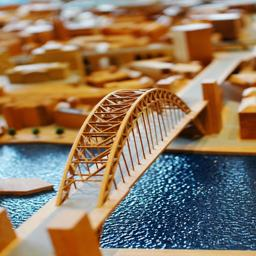

In [60]:
# Get prediction
with torch.no_grad():
    pathliminal = "binary classification data/val/liminal/" + random.sample(os.listdir("binary classification data/val/liminal"),1)[0]
    pathnormal = "binary classification data/val/normal/" + random.sample(os.listdir("binary classification data/val/normal"),1)[0]
    
    path = random.sample([pathliminal,pathnormal],1)[0]
    image = Image.open(path)
    image_tensor = data_transforms['val'](image)
    output = model(image_tensor.to(device).reshape(1,3,224,224))
    prediction = torch.argmax(output).item()

    if path == pathliminal:
        label = 0
    else:
        label=1

# Map prediction and label to class names
class_names = {0:'liminal',1:'normal'}
predicted_class = class_names[prediction]
actual_class = class_names[label]
print(f'prediction: {predicted_class}, label: {actual_class}')
image

liminal


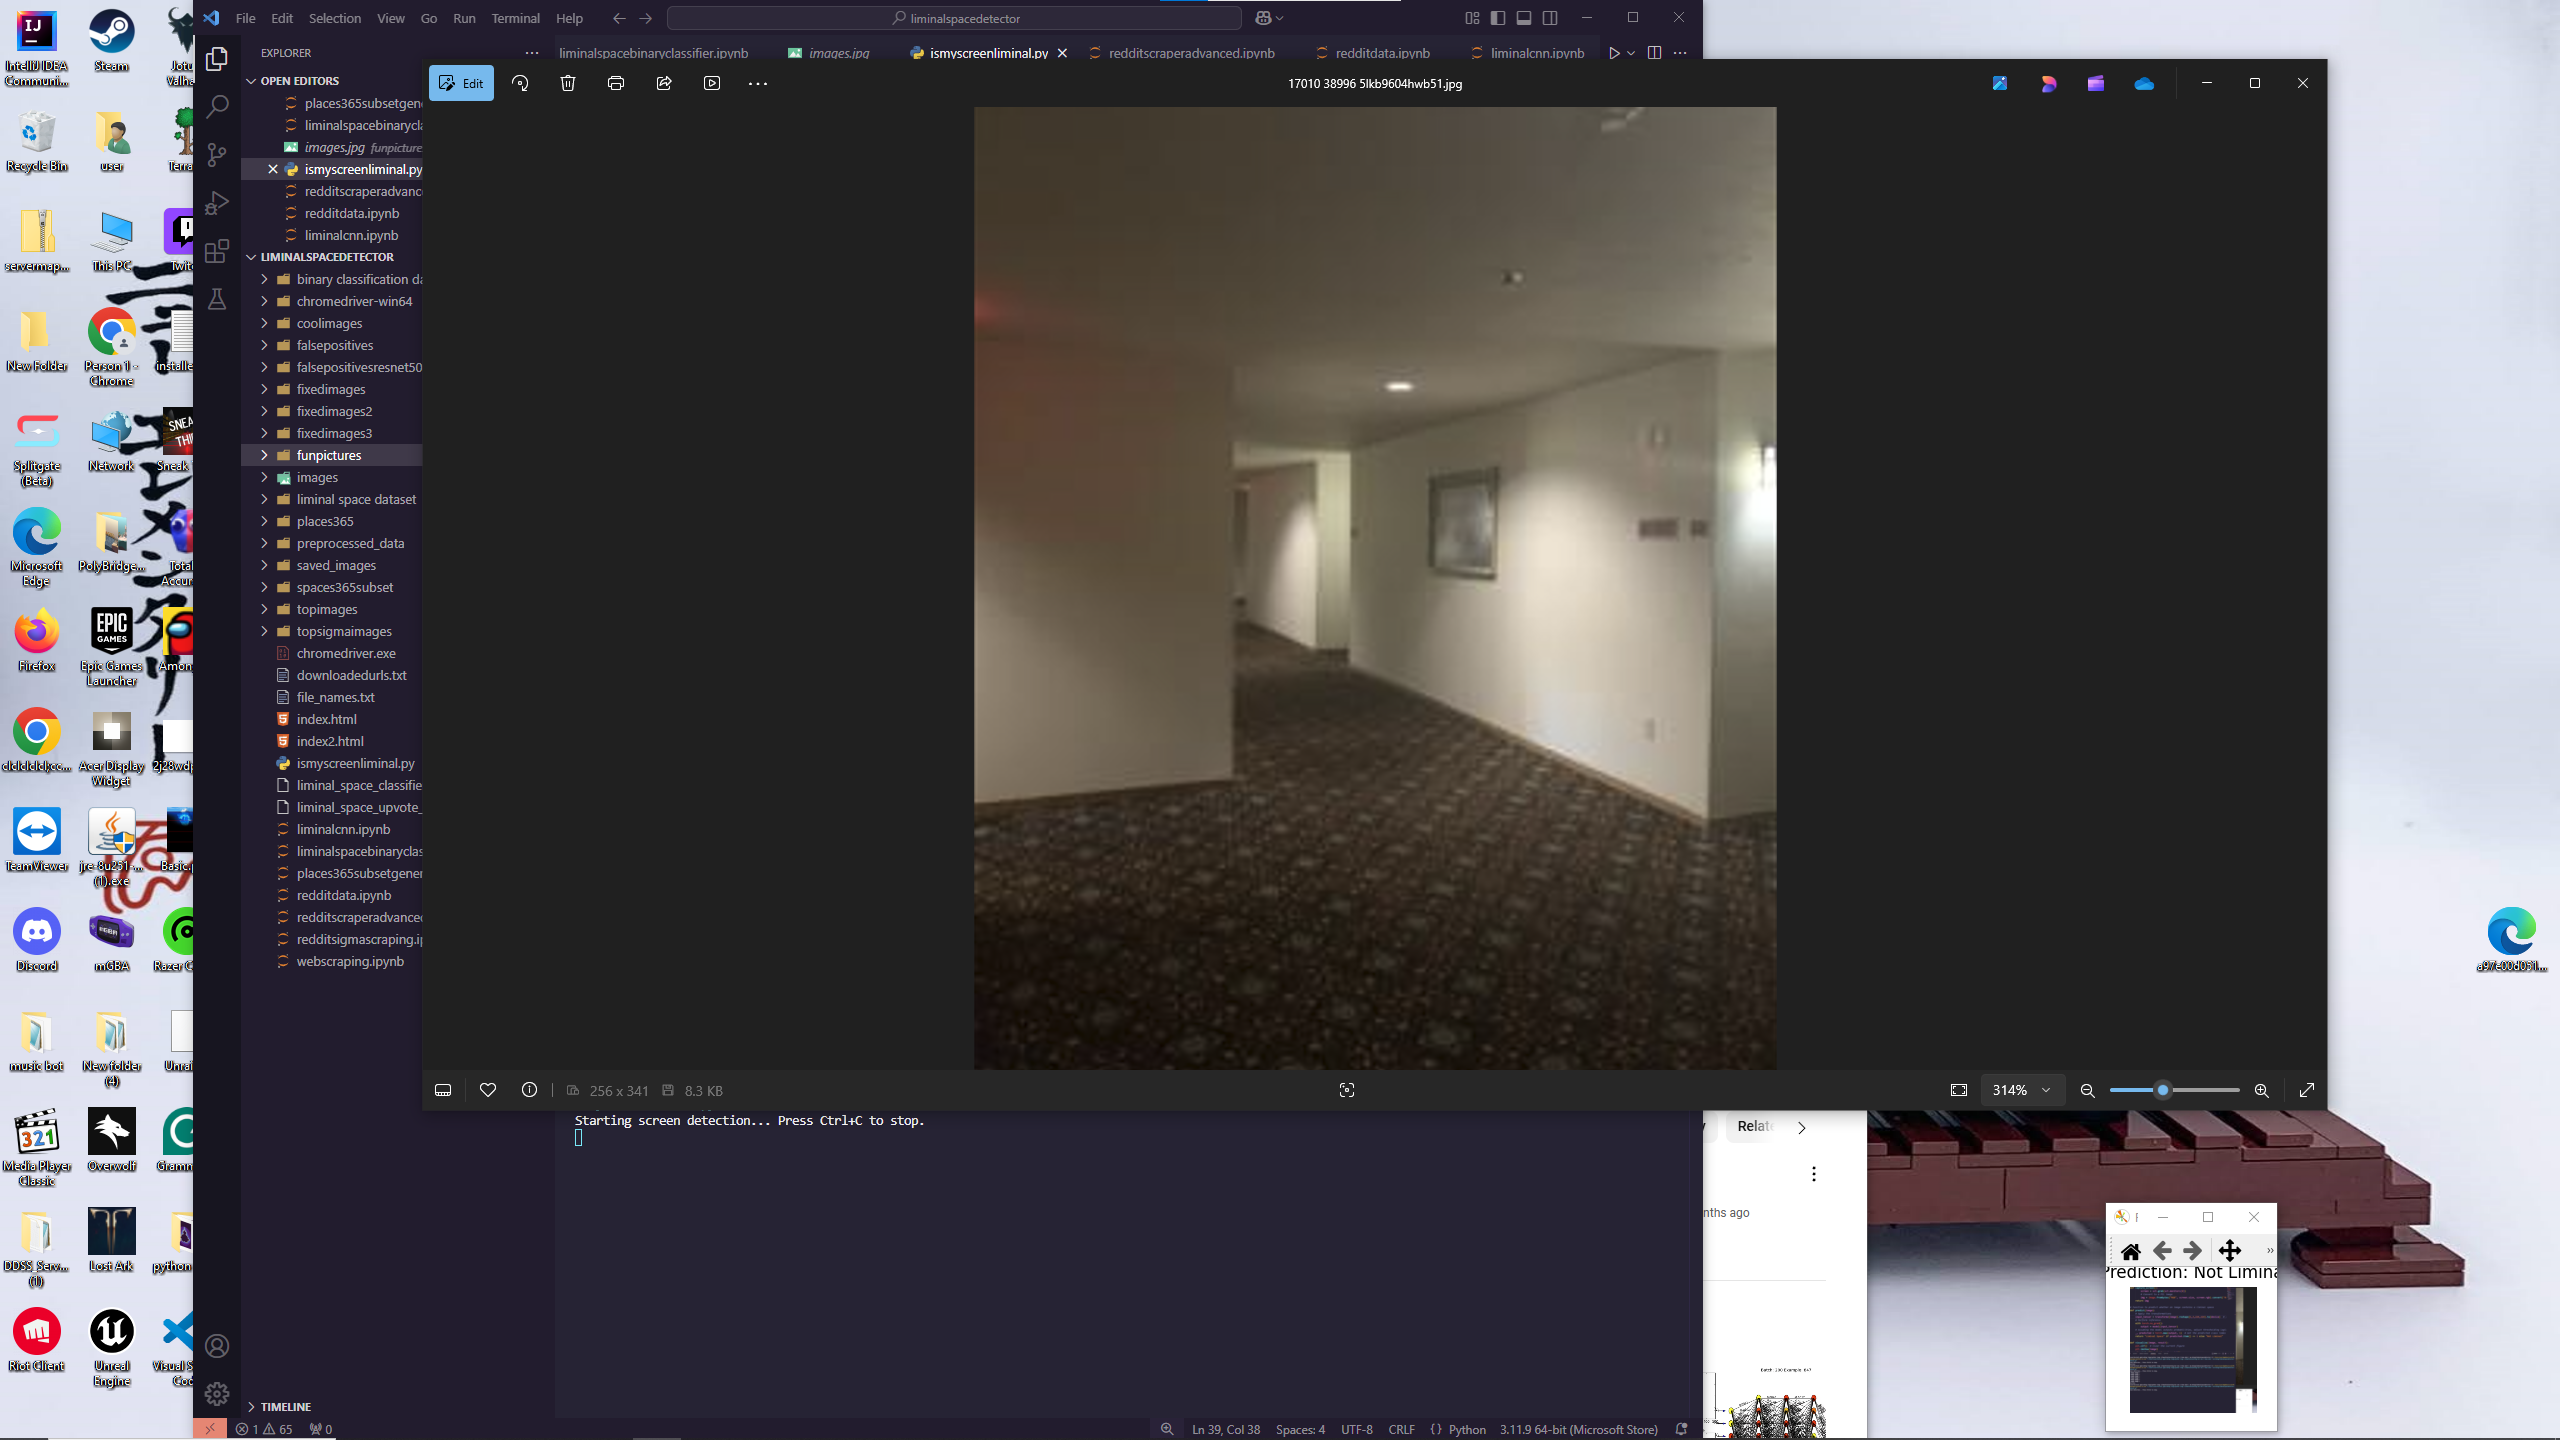

In [770]:
with torch.no_grad():
    path = 'funpictures/'+os.listdir('funpictures')[4]
    image = Image.open(path).convert('RGB')
    logits = model_conv(data_transforms['val'](image).to(device).reshape(1,3,224,224))
    print(class_names[torch.argmax(logits).item()])
image

In [477]:
falsenegatives = 0
falsepositives = 0
truepositives = 0
with torch.no_grad():
    for inputs,labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)
        falsenegatives += torch.sum((preds == False) & (labels == True))
        falsepositives += torch.sum((preds == True) & (labels == False))
        truepositives += torch.sum((preds == 1) & (labels == 1)).item()  # TP

# Calculate Precision, Recall, and F1 Score
    precision = truepositives / (truepositives + falsepositives) if (truepositives + falsepositives) > 0 else 0
    recall = truepositives / (truepositives + falsenegatives) if (truepositives + falsenegatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_score

In [481]:
falsepositives,falsenegatives

(tensor(144, device='cuda:0'), tensor(29, device='cuda:0'))

In [482]:
1-(falsepositives+falsenegatives)/1600

tensor(0.8919, device='cuda:0')

In [391]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Assuming the model and dataset are already prepared as in the notebook
# Replace 'model' and 'image_datasets' with the appropriate variables from your notebook

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations for validation
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load validation dataset
data_dir = 'binary classification data/val'  # Update this path if different
val_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

# Create a folder to save the images
output_folder = 'falsepositivesresnet50'
os.makedirs(output_folder, exist_ok=True)

# Iterate through images
for i in range(1600):
    # Randomly select an image and its label
    image_idx = i
    image, label = val_dataset[image_idx]

    # Prepare the image for the model
    image_tensor = image.unsqueeze(0).to(device)

    # Load model and set to evaluation mode
    # Replace 'model' with your trained model
    model = model_conv
    model.eval()

    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, prediction = torch.max(output, 1)

    # Map prediction and label to class names
    class_names = val_dataset.classes
    predicted_class = class_names[prediction.item()]
    actual_class = class_names[label]

    # Convert the image for plotting
    image_np = image.numpy().transpose(1, 2, 0) * std + mean
    image_np = np.clip(image_np, 0, 1)  # Ensure pixel values are in the range [0, 1]

    # Plot the image
    plt.imshow(image_np)
    plt.title(f"Predicted: {predicted_class}, Actual: {actual_class}")
    plt.axis('off')

    # Save the image to the folder
    if predicted_class == 'liminal' and actual_class == 'normal':    
        output_path = os.path.join(output_folder, f"image_{i + 1:04d}.png")
        plt.savefig(output_path, bbox_inches='tight')
    plt.close()  # Close the figure to free memory

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000019E2A5C1BC0>
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000019E2A5C1BC0>
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

In [790]:
torch.save(model_conv,'liminal_space_classifier.pth')